Import Libraries and Load Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('generated_dataset.csv')

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
   Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0               53.35               1105.13       12.87   
1               72.25               1026.31        3.42   
2               65.08                722.96        6.23   
3               60.71               1557.23       11.71   
4               46.19               1304.42        8.58   

   BOPD (barrel of oil produced per day)  \
0                                1378.93   
1                                1028.75   
2                                2017.92   
3                                 558.22   
4                                1280.47   

   BWPD (barrel of water produced per day)  BSW - basic solid and water (%)  \
0                                  2812.62                            75.64   
1                                   919.92                            44.21   
2                                  1212.42                            17.55   
3                                  

Data Exploration and Visualization

Missing values in each column:
Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
CR-corrosion defect                        0
dtype: int64


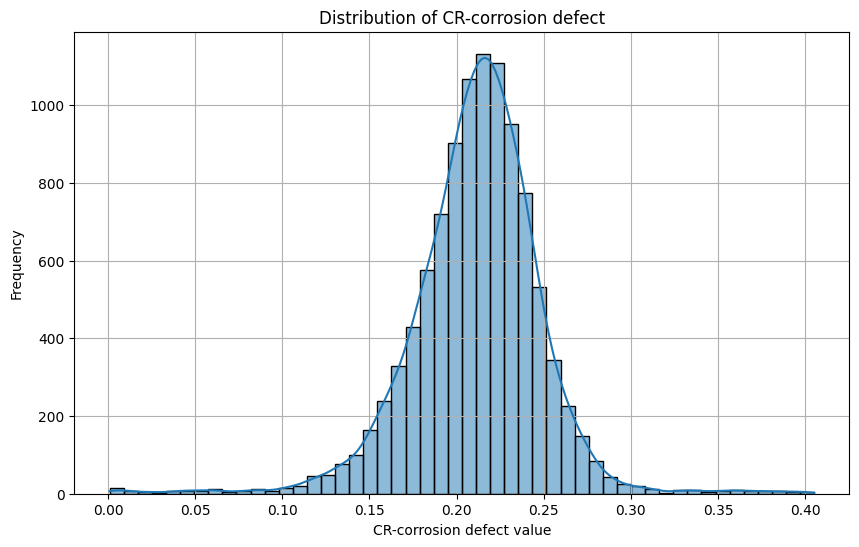

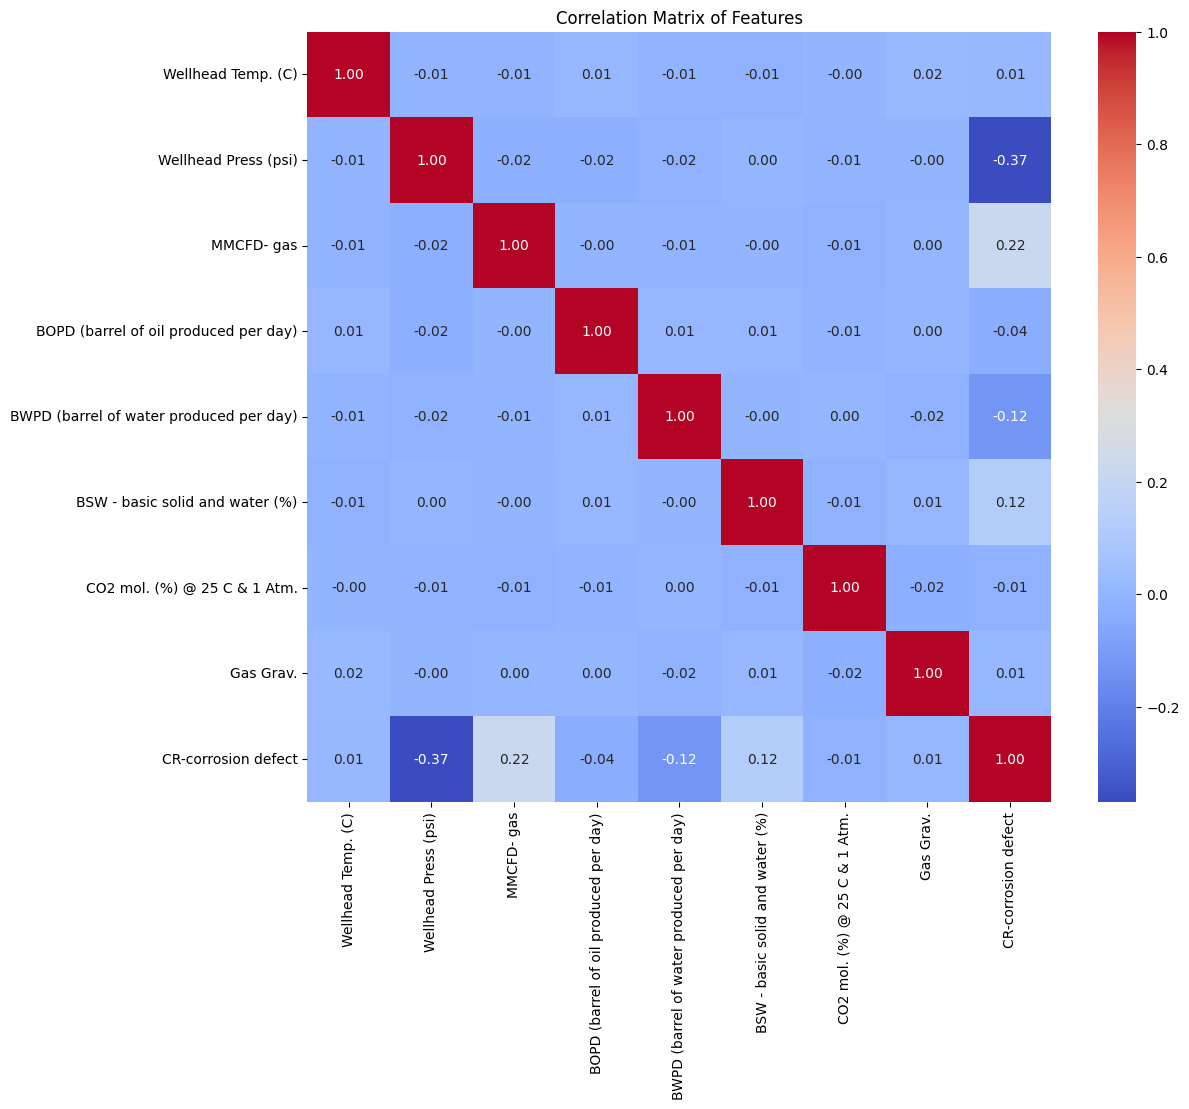

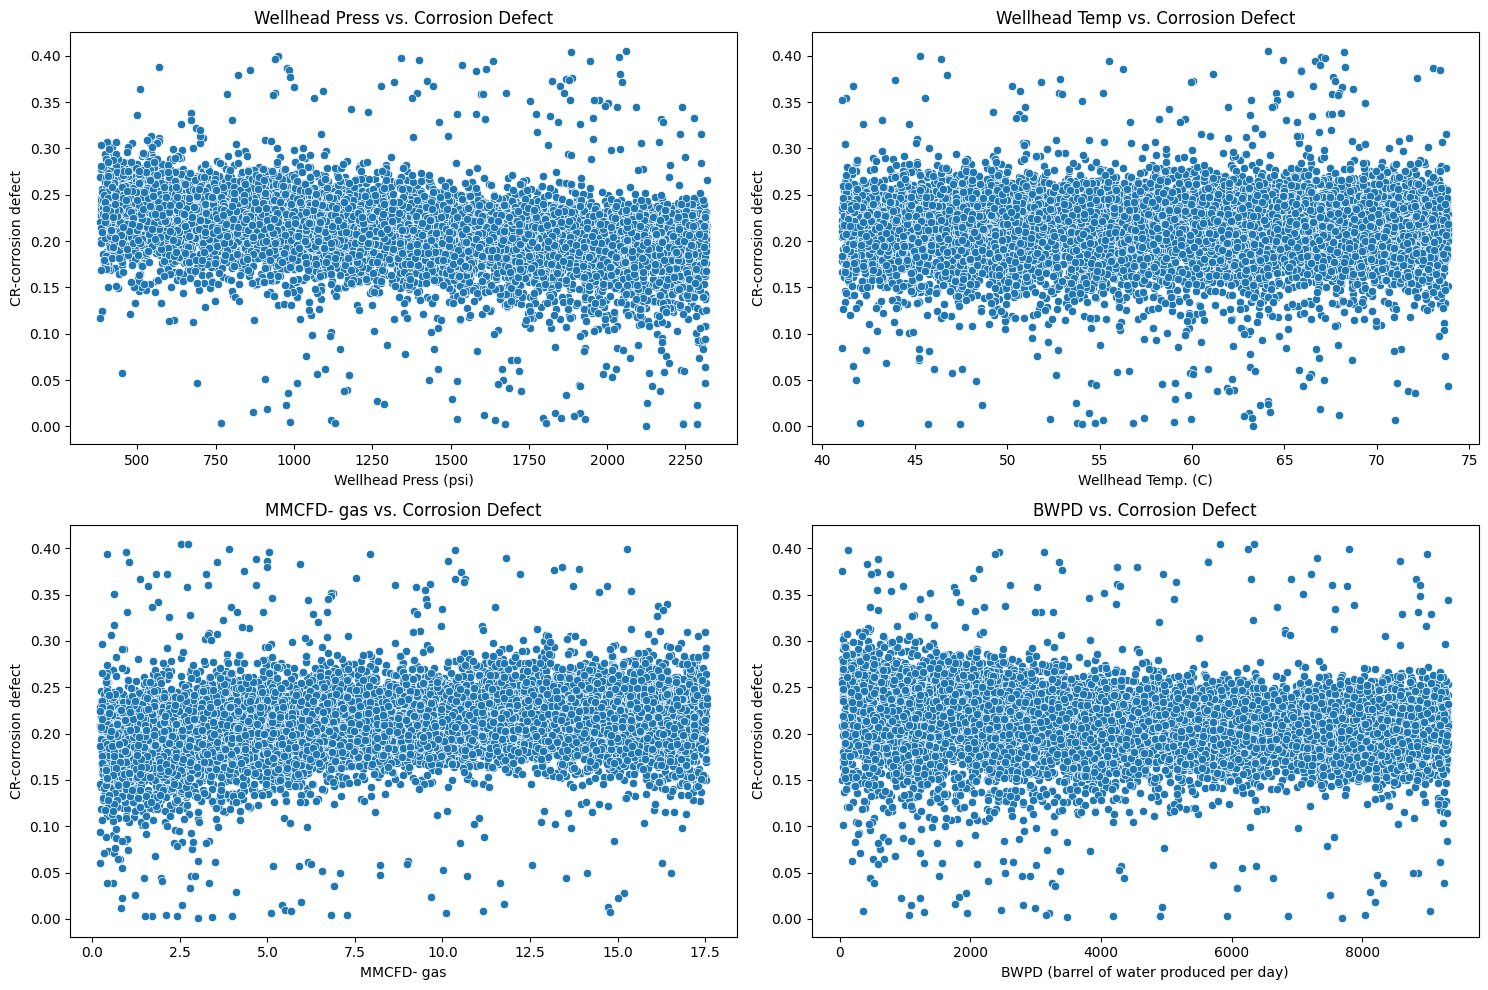

In [24]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Visualize the distribution of the target variable, 'CR-corrosion defect'
plt.figure(figsize=(10, 6))
sns.histplot(df['CR-corrosion defect'], kde=True, bins=50)
plt.title('Distribution of CR-corrosion defect')
plt.xlabel('CR-corrosion defect value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the correlation matrix of the features
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Visualize the relationships between features and the target variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='Wellhead Press (psi)', y='CR-corrosion defect', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Wellhead Press vs. Corrosion Defect')

sns.scatterplot(x='Wellhead Temp. (C)', y='CR-corrosion defect', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Wellhead Temp vs. Corrosion Defect')

sns.scatterplot(x='MMCFD- gas', y='CR-corrosion defect', data=df, ax=axes[1, 0])
axes[1, 0].set_title('MMCFD- gas vs. Corrosion Defect')

sns.scatterplot(x='BWPD (barrel of water produced per day)', y='CR-corrosion defect', data=df, ax=axes[1, 1])
axes[1, 1].set_title('BWPD vs. Corrosion Defect')

plt.tight_layout()
plt.show()

Data Preprocessing and Thresholding

In [25]:
# Define the threshold for 'leak' based on the 90th percentile of the 'CR-corrosion defect'
threshold = df['CR-corrosion defect'].quantile(0.90)
print(f"The 90th percentile threshold for 'CR-corrosion defect' is: {threshold:.4f}")

# Create the binary target variable 'is_leak'
df['is_leak'] = (df['CR-corrosion defect'] > threshold).astype(int)

# Drop the original continuous target and any irrelevant features for the model
df_model = df.drop(columns=['CR-corrosion defect'])

# Define features (X) and target (y)
X = df_model.drop('is_leak', axis=1)
y = df_model['is_leak']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training data into training and validation sets (75/25 split from the 80% original)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM, which expects a 3D input: [samples, timesteps, features]
# For this dataset, we treat each row as a single timestep
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print("\nData dimensions after preprocessing:")
print(f"X_train shape: {X_train_reshaped.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val_reshaped.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_reshaped.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the class distribution in the training set
print("\nClass distribution in the training set (before balancing):")
print(y_train.value_counts(normalize=True))

The 90th percentile threshold for 'CR-corrosion defect' is: 0.2503

Data dimensions after preprocessing:
X_train shape: (6174, 1, 8)
y_train shape: (6174,)
X_val shape: (2059, 1, 8)
y_val shape: (2059,)
X_test shape: (2059, 1, 8)
y_test shape: (2059,)

Class distribution in the training set (before balancing):
is_leak
0    0.900065
1    0.099935
Name: proportion, dtype: float64


Build and Train the Imbalanced Model

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9020 - loss: 0.5233 - val_accuracy: 0.9000 - val_loss: 0.3025
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8927 - loss: 0.3141 - val_accuracy: 0.9000 - val_loss: 0.2725
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.2797 - val_accuracy: 0.9000 - val_loss: 0.2501
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9068 - loss: 0.2497 - val_accuracy: 0.9038 - val_loss: 0.2423
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9055 - loss: 0.2524 - val_accuracy: 0.9038 - val_loss: 0.2392
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9015 - loss: 0.2522 - val_accuracy: 0.9043 - val_loss: 0.2376
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9043 - loss: 0.2492 - val_accuracy: 0.9058 - val_loss: 0.2350
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9130 - loss: 0.2493 - val_accuracy: 0.

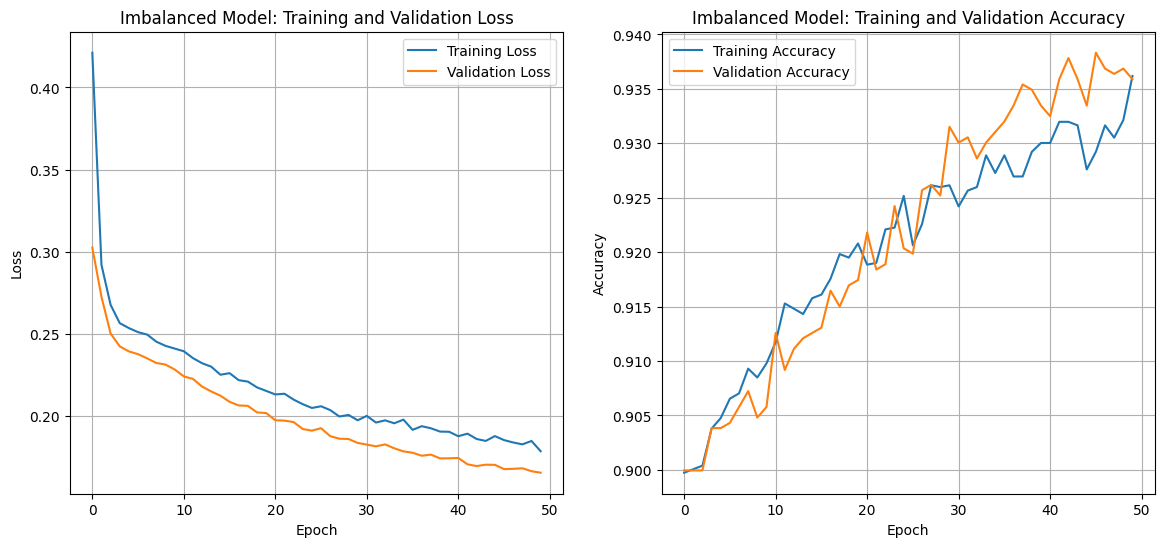


Imbalanced Model Test Accuracy: 0.9432
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Imbalanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1853
           1       0.96      0.45      0.61       206

    accuracy                           0.94      2059
   macro avg       0.95      0.72      0.79      2059
weighted avg       0.94      0.94      0.93      2059



In [26]:
# --- Model 1: Imbalanced Data ---

# Define the LSTM model architecture
model_imbalanced = Sequential()
model_imbalanced.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_imbalanced.add(Dropout(0.2))
model_imbalanced.add(Dense(1, activation='sigmoid'))

# Compile the model
model_imbalanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_imbalanced = model_imbalanced.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_imbalanced.history['loss'], label='Training Loss')
plt.plot(history_imbalanced.history['val_loss'], label='Validation Loss')
plt.title('Imbalanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_imbalanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_imbalanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Imbalanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss, accuracy = model_imbalanced.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nImbalanced Model Test Accuracy: {accuracy:.4f}")

# Generate predictions and classification report
y_pred_imbalanced = (model_imbalanced.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nImbalanced Model Classification Report:")
print(classification_report(y_test, y_pred_imbalanced))

Calculated Class Weights:
{0: 0.5555155659528522, 1: 5.003241491085899}
Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7333 - loss: 0.6794 - val_accuracy: 0.8106 - val_loss: 0.6053
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7793 - loss: 0.6081 - val_accuracy: 0.7460 - val_loss: 0.5368
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7602 - loss: 0.5156 - val_accuracy: 0.7431 - val_loss: 0.5140
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7497 - loss: 0.5177 - val_accuracy: 0.7717 - val_loss: 0.4851
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7591 - loss: 0.5151 - val_accuracy: 0.7878 - val_loss: 0.4656
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7453 - loss: 0.5497 - val_accuracy: 0.7635 - val_loss: 0.4994
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.4933 - val_accuracy: 0.7688 - val_loss: 0.4825
Epoch 8/50
193/193 ━━━━━━━━━━━━━

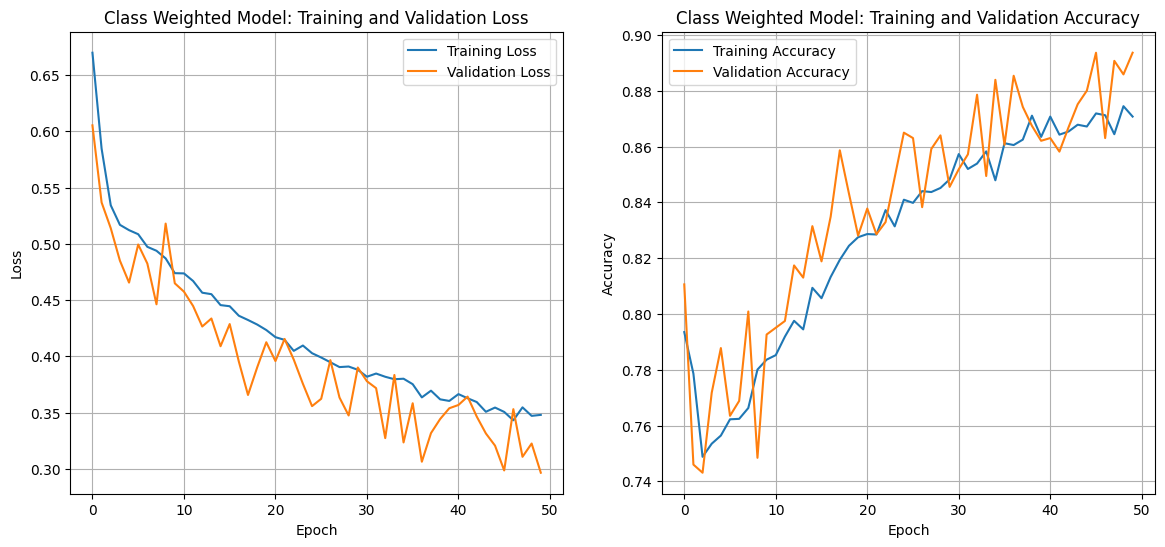


Class Weighted Model Test Accuracy: 0.8941
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Class Weighted Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1853
           1       0.48      0.85      0.62       206

    accuracy                           0.89      2059
   macro avg       0.73      0.87      0.78      2059
weighted avg       0.93      0.89      0.91      2059



In [27]:
from sklearn.utils import class_weight

# --- Model 2 (Alternative): Using Class Weights ---

# Calculate class weights to handle imbalanced data
unique_classes = np.unique(y_train)
if len(unique_classes) < 2:
    print("Warning: Only one class found in the training data. Class weights will not be used.")
    class_weights_dict = None
else:
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=y_train
    )
    class_weights_dict = dict(zip(unique_classes, class_weights))
    print("Calculated Class Weights:")
    print(class_weights_dict)

# Define the LSTM model architecture
model_weighted = Sequential()
model_weighted.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_weighted.add(Dropout(0.2))
model_weighted.add(Dense(1, activation='sigmoid'))

# Compile the model
model_weighted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the original (imbalanced) training data, but with class weights
# Pass y_train as a NumPy array using .values to avoid indexing issues
history_weighted = model_weighted.fit(
    X_train_reshaped, y_train.values,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val.values),
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_weighted.history['loss'], label='Training Loss')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss')
plt.title('Class Weighted Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_weighted.history['accuracy'], label='Training Accuracy')
plt.plot(history_weighted.history['val_accuracy'], label='Validation Accuracy')
plt.title('Class Weighted Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss_weighted, accuracy_weighted = model_weighted.evaluate(X_test_reshaped, y_test.values, verbose=0)
print(f"\nClass Weighted Model Test Accuracy: {accuracy_weighted:.4f}")

# Generate predictions and classification report
y_pred_weighted = (model_weighted.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nClass Weighted Model Classification Report:")
print(classification_report(y_test, y_pred_weighted))

Balance the Data with SMOTE

Class distribution in the training set after SMOTE:
is_leak
0    0.5
1    0.5
Name: proportion, dtype: float64
Resampled X_train shape: (11114, 1, 8)
Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6783 - loss: 0.6514 - val_accuracy: 0.7907 - val_loss: 0.4692
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7693 - loss: 0.5063 - val_accuracy: 0.7829 - val_loss: 0.4585
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7795 - loss: 0.4898 - val_accuracy: 0.8014 - val_loss: 0.4317
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7948 - loss: 0.4653 - val_accuracy: 0.7746 - val_loss: 0.4702
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8163 - loss: 0.4405 - val_accuracy: 0.8315 - val_loss: 0.3952
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8308 - loss: 0.4196 - val_accuracy: 0.8213 - val_loss: 0.4062
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8407 - loss: 0.3

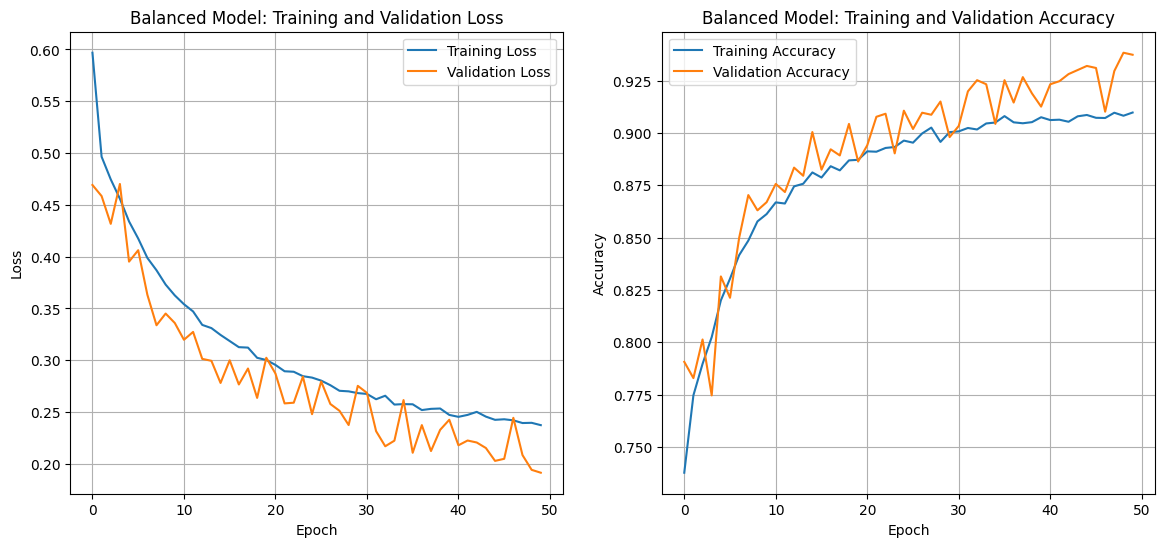


Balanced Model Test Accuracy: 0.9349
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Balanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1853
           1       0.63      0.84      0.72       206

    accuracy                           0.93      2059
   macro avg       0.81      0.89      0.84      2059
weighted avg       0.95      0.93      0.94      2059



In [28]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Reshape the 3D data back to 2D for SMOTE
X_train_2d = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

# Reshape the data back to 3D for LSTM
X_train_resampled_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])

print("Class distribution in the training set after SMOTE:")
print(y_train_resampled.value_counts(normalize=True))
print(f"Resampled X_train shape: {X_train_resampled_reshaped.shape}")

# --- Model 2: Balanced Data ---
# Define the LSTM model architecture (same as before for a fair comparison)
model_balanced = Sequential()
model_balanced.add(LSTM(50, activation='relu', input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])))
model_balanced.add(Dropout(0.2))
model_balanced.add(Dense(1, activation='sigmoid'))

# Compile the model
model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the balanced data
history_balanced = model_balanced.fit(
    X_train_resampled_reshaped, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['loss'], label='Training Loss')
plt.plot(history_balanced.history['val_loss'], label='Validation Loss')
plt.title('Balanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_balanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Balanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss_balanced, accuracy_balanced = model_balanced.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nBalanced Model Test Accuracy: {accuracy_balanced:.4f}")

# Generate predictions and classification report
y_pred_balanced = (model_balanced.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nBalanced Model Classification Report:")
print(classification_report(y_test, y_pred_balanced))

Hyperparameter Tuning with Keras Tuner - No Resampling

Reloading Tuner from my_tuner_dir_no_smote/pipeline_leak_detection/tuner0.json


Starting hyperparameter tuning...

Optimal Hyperparameters found by the tuner:
LSTM Units: 96
Dropout Rate: 0.5
Learning Rate: 0.01
Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9320 - loss: 0.1923 - val_accuracy: 0.9500 - val_loss: 0.1557
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9363 - loss: 0.1807 - val_accuracy: 0.9242 - val_loss: 0.1732
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9325 - loss: 0.2029 - val_accuracy: 0.9432 - val_loss: 0.1523
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9381 - loss: 0.1860 - val_accuracy: 0.9568 - val_loss: 0.1518
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9340 - loss: 0.1823 - val_accuracy: 0.9359 - val_loss: 0.1594
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9352 - loss: 0.1874 - val_accuracy: 0.9369 - val_loss: 0.1570
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9420 - loss: 0.1713 - val_accuracy

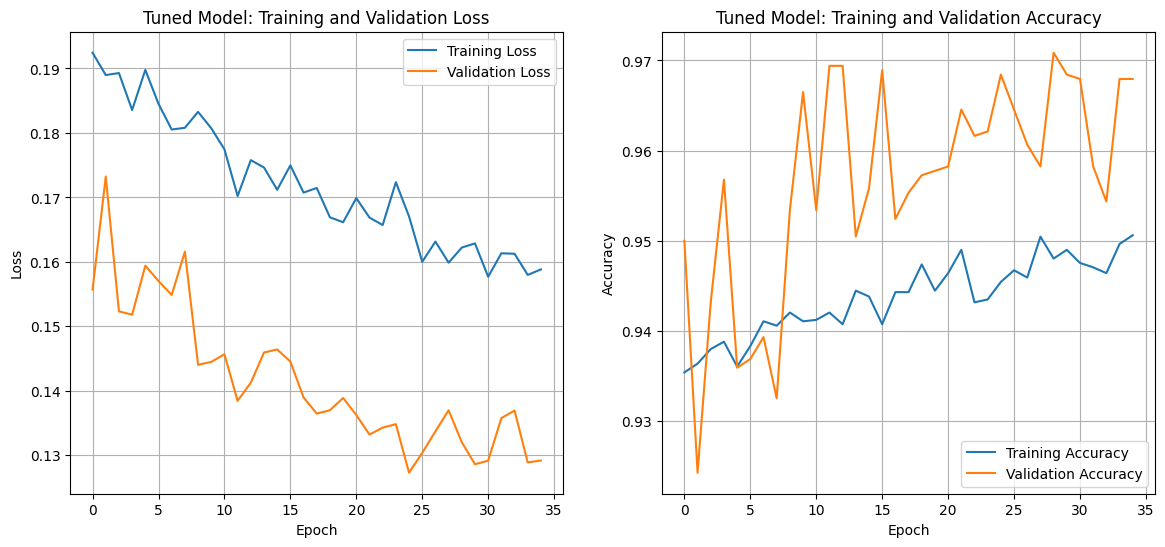


Tuned Model Test Accuracy: 0.9607
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1853
           1       0.93      0.66      0.77       206

    accuracy                           0.96      2059
   macro avg       0.95      0.82      0.87      2059
weighted avg       0.96      0.96      0.96      2059



In [29]:
import tensorflow as tf
import keras_tuner as kt

# Define a function that returns a compiled model for Keras Tuner
def build_tuner_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])
    ))
    model.add(Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuner_dir_no_smote',
    project_name='pipeline_leak_detection'
)

# Run the hyperparameter search
print("Starting hyperparameter tuning...")
tuner.search(
    X_train_reshaped,
    y_train,
    epochs=20,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nOptimal Hyperparameters found by the tuner:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Retrieve the best model and train it
model_tuned = tuner.get_best_models(num_models=1)[0]
history_tuned = model_tuned.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the best model on the test set
loss_tuned, accuracy_tuned = model_tuned.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nTuned Model Test Accuracy: {accuracy_tuned:.4f}")

# Generate predictions and classification report
y_pred_tuned = (model_tuned.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


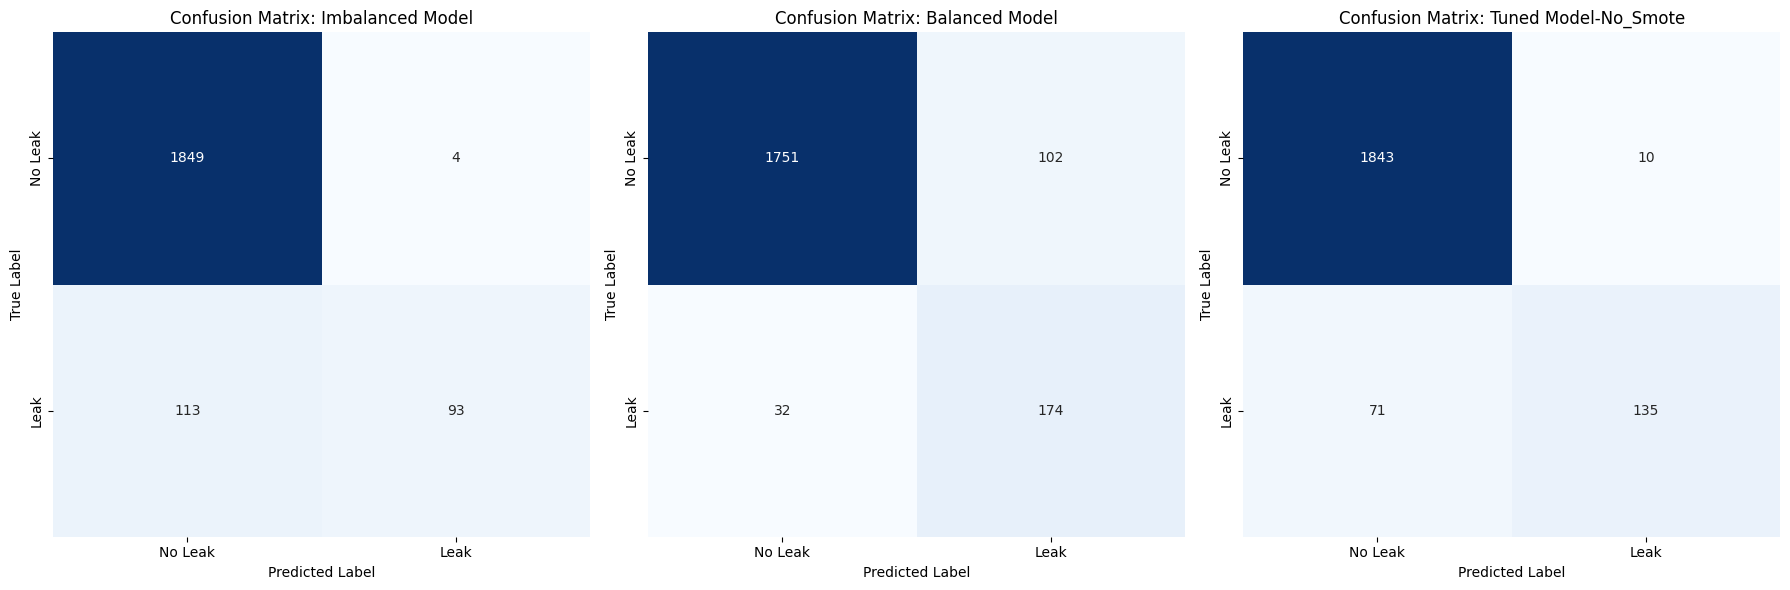

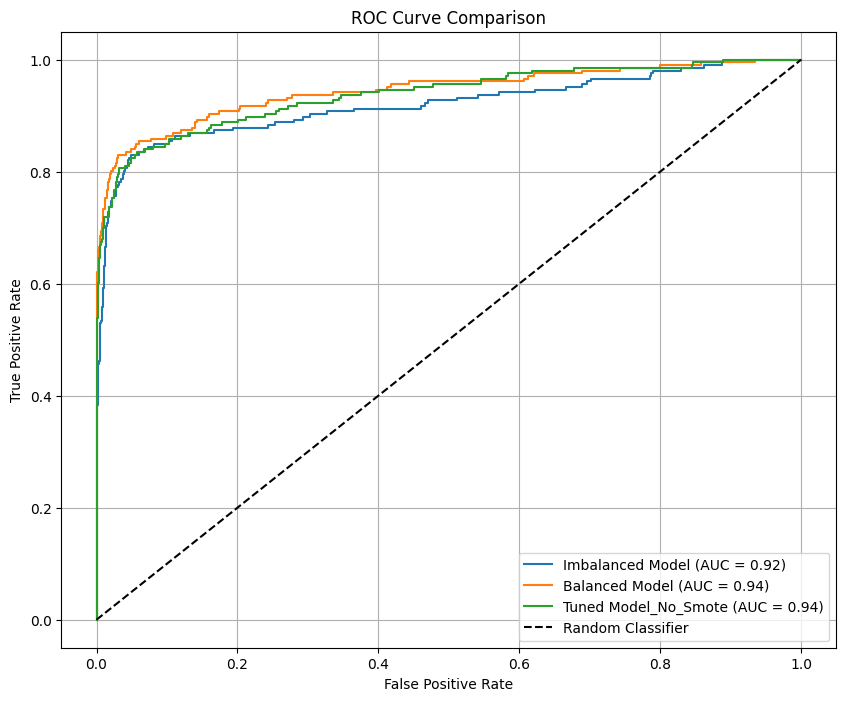

--- Classification Report Comparison ---

--- Imbalanced Model ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1853
           1       0.96      0.45      0.61       206

    accuracy                           0.94      2059
   macro avg       0.95      0.72      0.79      2059
weighted avg       0.94      0.94      0.93      2059


--- Balanced Model ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1853
           1       0.63      0.84      0.72       206

    accuracy                           0.93      2059
   macro avg       0.81      0.89      0.84      2059
weighted avg       0.95      0.93      0.94      2059


--- Tuned Model - No Smote ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1853
           1       0.93      0.66      0.77       206

    accuracy                           0.96      2059
   ma

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Evaluate and Visualize All Models ---

# Get predictions for all models on the test set
y_pred_imbalanced = (model_imbalanced.predict(X_test_reshaped) > 0.5).astype("int32")
y_pred_balanced = (model_balanced.predict(X_test_reshaped) > 0.5).astype("int32")
y_pred_tuned = (model_tuned.predict(X_test_reshaped) > 0.5).astype("int32")

# Get prediction probabilities for ROC curve
y_prob_imbalanced = model_imbalanced.predict(X_test_reshaped).ravel()
y_prob_balanced = model_balanced.predict(X_test_reshaped).ravel()
y_prob_tuned = model_tuned.predict(X_test_reshaped).ravel()

# Create a function to plot the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticklabels(['No Leak', 'Leak'])
    ax.set_yticklabels(['No Leak', 'Leak'])

# Visualize Confusion Matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_confusion_matrix(y_test, y_pred_imbalanced, "Imbalanced Model", axes[0])
plot_confusion_matrix(y_test, y_pred_balanced, "Balanced Model", axes[1])
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Model-No_Smote", axes[2])
plt.tight_layout()
plt.show()

# Visualize ROC Curves side-by-side
plt.figure(figsize=(10, 8))

# ROC for Imbalanced Model
fpr_imbalanced, tpr_imbalanced, _ = roc_curve(y_test, y_prob_imbalanced)
roc_auc_imbalanced = auc(fpr_imbalanced, tpr_imbalanced)
plt.plot(fpr_imbalanced, tpr_imbalanced, label=f'Imbalanced Model (AUC = {roc_auc_imbalanced:.2f})')

# ROC for Balanced Model
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Model (AUC = {roc_auc_balanced:.2f})')

# ROC for Tuned Model_No_Smote
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Model_No_Smote (AUC = {roc_auc_tuned:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print and compare the full classification reports
print("--- Classification Report Comparison ---")
print("\n--- Imbalanced Model ---")
print(classification_report(y_test, y_pred_imbalanced))
print("\n--- Balanced Model ---")
print(classification_report(y_test, y_pred_balanced))
print("\n--- Tuned Model - No Smote ---")
print(classification_report(y_test, y_pred_tuned))

Hyperparameter Tuning with Keras Tuner - with resampling

Reloading Tuner from my_tuner_dir_with_smote/pipeline_leak_detection/tuner0.json
Starting hyperparameter tuning...

Optimal Hyperparameters found by the tuner:
LSTM Units: 128
Dropout Rate: 0.30000000000000004
Learning Rate: 0.01
Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9030 - loss: 0.2467 - val_accuracy: 0.9505 - val_loss: 0.1726
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9081 - loss: 0.2303 - val_accuracy: 0.9150 - val_loss: 0.2365
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9017 - loss: 0.2481 - val_accuracy: 0.9437 - val_loss: 0.1768
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9077 - loss: 0.2309 - val_accuracy: 0.9131 - val_loss: 0.2526
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9098 - loss: 0.2173 - val_accuracy: 0.9174 - val_loss: 0.2407
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9052 - loss: 0.2285 - val_accuracy: 0.9500 - val_loss: 0.1519
Ep

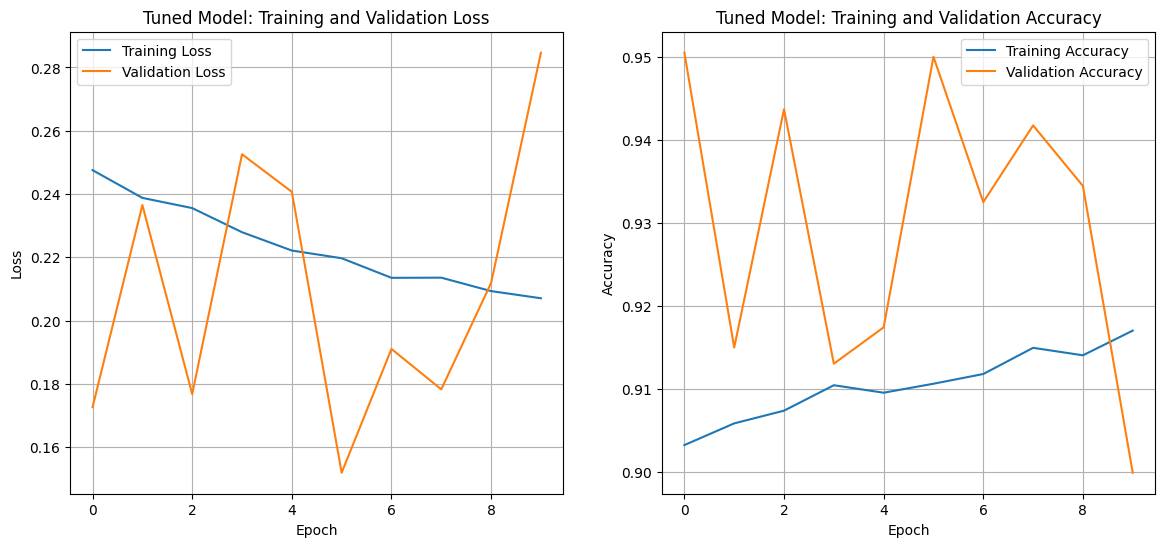


Tuned Model Test Accuracy: 0.9480
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1853
           1       0.93      0.66      0.77       206

    accuracy                           0.96      2059
   macro avg       0.95      0.82      0.87      2059
weighted avg       0.96      0.96      0.96      2059



In [31]:
import tensorflow as tf
import keras_tuner as kt

# Define a function that returns a compiled model for Keras Tuner
def build_tuner_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])
    ))
    model.add(Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuner_dir_with_smote',
    project_name='pipeline_leak_detection'
)

# Run the hyperparameter search
print("Starting hyperparameter tuning...")
tuner.search(
    X_train_resampled_reshaped,
    y_train_resampled,
    epochs=20,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nOptimal Hyperparameters found by the tuner:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Retrieve the best model and train it
model_tuned = tuner.get_best_models(num_models=1)[0]
history_tuned = model_tuned.fit(
    X_train_resampled_reshaped, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the best model on the test set
loss_tuned, accuracy_tuned = model_tuned.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nTuned Model Test Accuracy: {accuracy_tuned:.4f}")

# Generate predictions and classification report
y_pred_tuned_smote = (model_tuned.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))

 Performance Evaluation and Visual Comparison

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


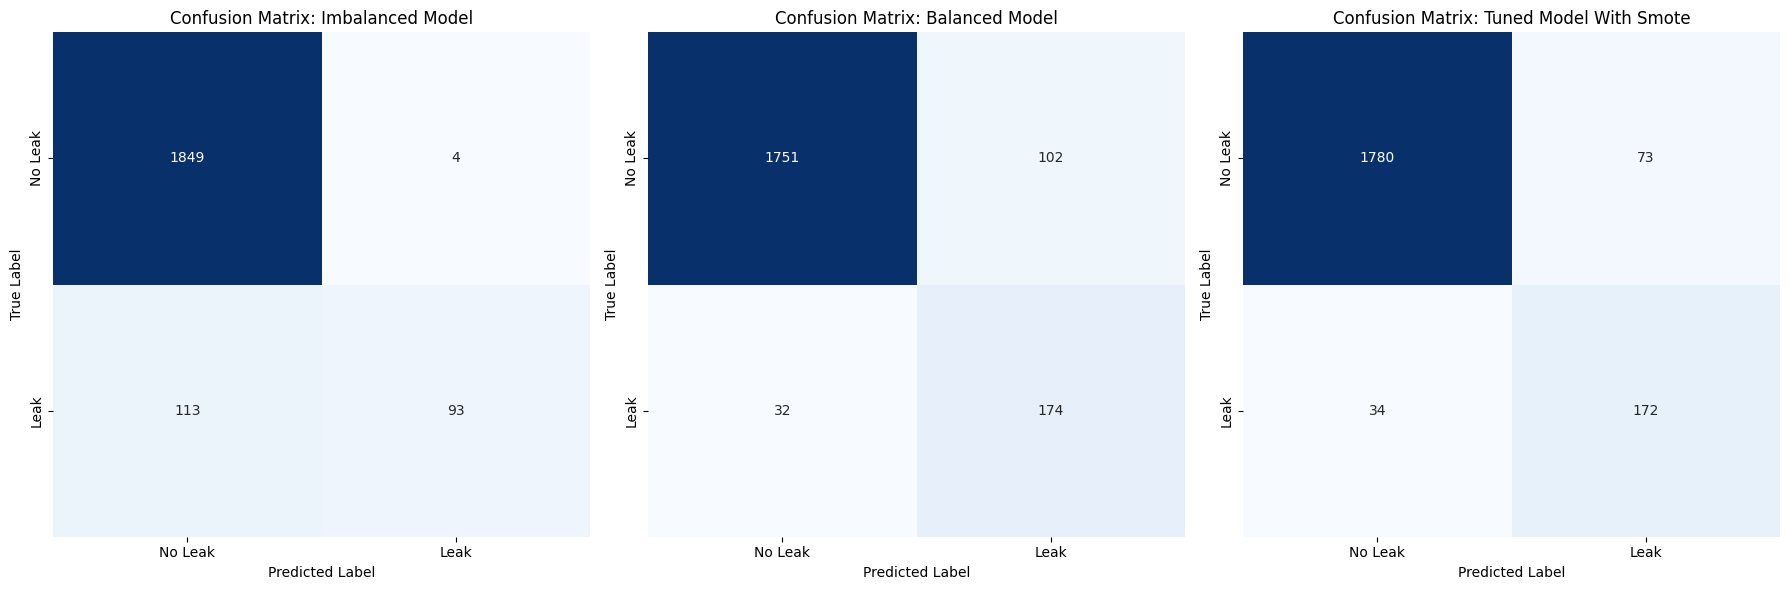

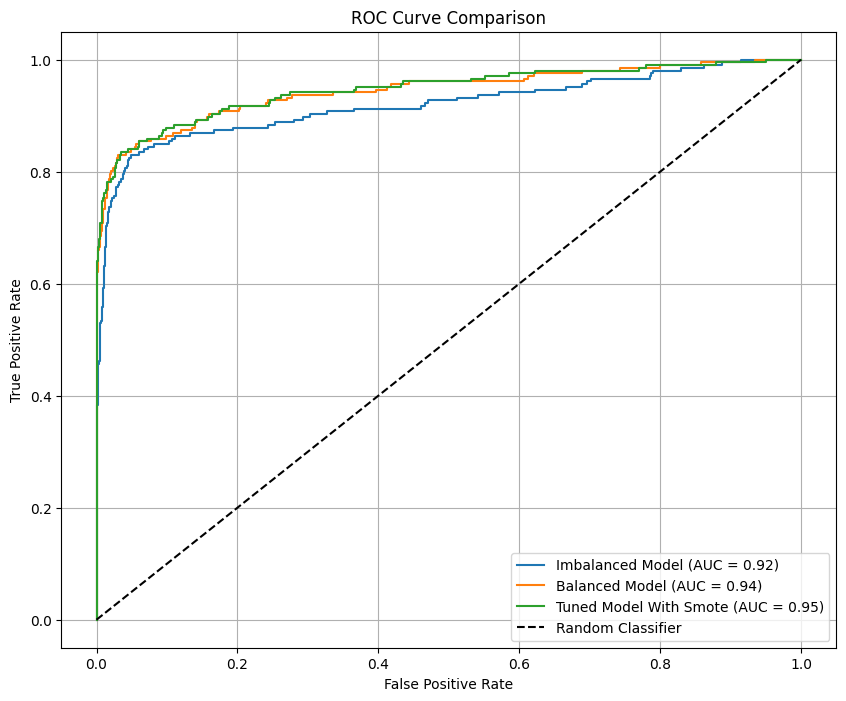

--- Classification Report Comparison ---

--- Imbalanced Model ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1853
           1       0.96      0.45      0.61       206

    accuracy                           0.94      2059
   macro avg       0.95      0.72      0.79      2059
weighted avg       0.94      0.94      0.93      2059


--- Balanced Model ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1853
           1       0.63      0.84      0.72       206

    accuracy                           0.93      2059
   macro avg       0.81      0.89      0.84      2059
weighted avg       0.95      0.93      0.94      2059


--- Tuned Model With Smote ---
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1853
           1       0.70      0.83      0.76       206

    accuracy                           0.95      2059
   ma

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Evaluate and Visualize All Models ---

# Get predictions for all models on the test set
y_pred_imbalanced = (model_imbalanced.predict(X_test_reshaped) > 0.5).astype("int32")
y_pred_balanced = (model_balanced.predict(X_test_reshaped) > 0.5).astype("int32")
y_pred_tuned = (model_tuned.predict(X_test_reshaped) > 0.5).astype("int32")

# Get prediction probabilities for ROC curve
y_prob_imbalanced = model_imbalanced.predict(X_test_reshaped).ravel()
y_prob_balanced = model_balanced.predict(X_test_reshaped).ravel()
y_prob_tuned = model_tuned.predict(X_test_reshaped).ravel()

# Create a function to plot the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticklabels(['No Leak', 'Leak'])
    ax.set_yticklabels(['No Leak', 'Leak'])

# Visualize Confusion Matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_confusion_matrix(y_test, y_pred_imbalanced, "Imbalanced Model", axes[0])
plot_confusion_matrix(y_test, y_pred_balanced, "Balanced Model", axes[1])
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Model With Smote", axes[2])
plt.tight_layout()
plt.show()

# Visualize ROC Curves side-by-side
plt.figure(figsize=(10, 8))

# ROC for Imbalanced Model
fpr_imbalanced, tpr_imbalanced, _ = roc_curve(y_test, y_prob_imbalanced)
roc_auc_imbalanced = auc(fpr_imbalanced, tpr_imbalanced)
plt.plot(fpr_imbalanced, tpr_imbalanced, label=f'Imbalanced Model (AUC = {roc_auc_imbalanced:.2f})')

# ROC for Balanced Model
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Model (AUC = {roc_auc_balanced:.2f})')

# ROC for Tuned Model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Model With Smote (AUC = {roc_auc_tuned:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print and compare the full classification reports
print("--- Classification Report Comparison ---")
print("\n--- Imbalanced Model ---")
print(classification_report(y_test, y_pred_imbalanced))
print("\n--- Balanced Model ---")
print(classification_report(y_test, y_pred_balanced))
print("\n--- Tuned Model With Smote ---")
print(classification_report(y_test, y_pred_tuned))